In [2]:
import gc

import torch
import utils
import enumeration
import utils_func
import torch
import gc

from torchvision.transforms import transforms
# set seed for the reproducibility of the results


gc.collect()
torch.cuda.empty_cache()


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAMES_DICT = {
    "SAT": "Engstrom2019Robustness",
}

/home/robustgen/miniconda3/envs/robustbench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# parse arguments
import argparse

PARSER = argparse.ArgumentParser(description="Process some parameters.")
PARSER.add_argument("--wandb_logging", type=bool, default=False, help="log to wandb")
PARSER.add_argument("--batch_size", type=int, default=64, help="batch size")
PARSER.add_argument(
    "--dataset",
    type=str,
    default="cifar10",
    choices=["cifar10", "cifar100"],
    help="dataset",
)
PARSER.add_argument("--epsilon", type=float, default=8 / 255, help="epsilon")
PARSER.add_argument("--alpha", type=float, default=2 / 255, help="alpha")
PARSER.add_argument(
    "--sampling_iterations", type=int, default=20, help="sampling iterations"
)
PARSER.add_argument(
    "--architecture_name", type=str, default="WideResNet", help="architecture name"
)
PARSER.add_argument(
    "--from_robustbench", type=bool, default=True, help="load model from robustbench"
)
PARSER.add_argument(
    "--init",
    type=str,
    default="random",
    choices=["random", "pca", "gaussian", "informative", "informative+pca"],
    help="initialization for the generation",
)

PARSER.add_argument("--seed", type=int, default=0, help="random seed")
PARSER.add_argument("--data_dir", type=str, default="./data", help="data directory")
PARSER.add_argument(
    "--model_name",
    type=str,
    default="Zhang2019Theoretically",
    choices=[MODEL_NAMES_DICT.keys()],
    help="define the name of the model to be loaded",
)
PARSER.add_argument(
    "--model_source",
    type=str,
    default="robustbench",
    choices=["robustbench", "jem", "local"],
    help="the source from where the model is loaded",
)
PARSER.add_argument(
    "--model_dir",
    type=str,
    default="./models",
)
PARSER.add_argument(
    "--threat model",
    type=str,
    default="Linf",
    choices=["Linf", "L2"],
    help="threat model",
)


try:
    args = PARSER.parse_args()
    wandb = args.wandb_logging
    batch_size = args.batch_size
    dataset = args.dataset
    epsilon = args.epsilon
    alpha = args.alpha
    sampling_iterations = args.sampling_iterations
    architecture_name = args.architecture_name
    from_robustbench = args.from_robustbench
    seed = args.seed
    model_name = args.model_name
    model_source = args.model_source
    data_dir = args.data_dir    
    threat_model = args.threat_model

    print("Using arguments from parser")

except:
    print("Using default arguments")
    wandb = False
    batch_size = 64
    dataset = "cifar10"
    epsilon = 8 / 255
    alpha = 2 / 255
    sampling_iterations = 20
    architecture_name = "WideResNet"
    from_robustbench = True
    init = "random"
    data_dir = "./data"
    seed = 0
    model_name = "Wang2020Improving"
    source = 'robustbench'
    model_dir = "./models"
    threat_model = "L2"

from utils import fix_seed

fix_seed(seed=seed)


# logging on wandb
if wandb:
    import wandb

    config = {
        "dataset": dataset,
        "batch_size": batch_size,
        "epsilon": epsilon,
        "alpha": alpha,
        "sampling_iterations": sampling_iterations,
        "architecture name": architecture_name,
        "from_robustbench": from_robustbench,
        "initialization": init,
        "model name": model_name,
        "model source": model_source,
    }
    wandb.init(name="generation", project="LE-PGD", entity="le-pgd", config=config)

Using default arguments


In [4]:
TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

DATASET_TRAIN, DATASET_TEST = utils.load_clean_dataset(
    dataset=enumeration.BenchmarkDataset(dataset.lower()),
    n_examples=None,
    data_dir=data_dir,
    transform=TRANSFORM,
)
BATCH_SIZE =len(DATASET_TRAIN) 
print(BATCH_SIZE)
TRAIN_DATALOADER = torch.utils.data.DataLoader(
    DATASET_TRAIN, batch_size=BATCH_SIZE, shuffle=True
)

TEST_DATALOADER = torch.utils.data.DataLoader(
    DATASET_TEST, batch_size=BATCH_SIZE, shuffle=False
)

Files already downloaded and verified
Files already downloaded and verified
50000


In [5]:

from JEMPP.models.wideresnet import Wide_ResNet as WideResNet

ARCHITECTURE_DICT = {"wideresnet": WideResNet}

assert architecture_name.lower() in ARCHITECTURE_DICT.keys()
from robustbench.utils import load_model
from torch import nn
from JEMPP.models.jem_models import F, CCF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS = {m_name: None for m_name in MODEL_NAMES_DICT.keys()}

for model_name_i, MODEL_NAMES_DICT_model_name_i in MODEL_NAMES_DICT.items():

    if model_source == "robustbench":
        model = load_model(
            model_name=MODEL_NAMES_DICT_model_name_i,
            dataset=dataset,
            threat_model=threat_model,
            
            model_dir="./models",
        )
        model = nn.DataParallel(model, device_ids=[0])
        model.to(device)
    elif model_source == "jem":
        model_cls = F
        model = model_cls(
            enumeration.dataset_image_size[dataset],
            enumeration.dataset_num_classes[dataset],
            norm="batch",
            n_classes=enumeration.dataset_num_classes[dataset],
            model="wrn",
        )
        ckpt_dict = torch.load("./models/cifar10/Linf/sadajem5_95.5_9.4.pt")
        model.load_state_dict(ckpt_dict["model_state_dict"])
        model = nn.DataParallel(model, device_ids=[0, 1])
        model.to(device)

    elif model_source == "local":
        model_path = model_dir + "/wandb_model/" + model_name + ".pt"
        # check missimg 2 factors in architecture instanciation
        model = (
            ARCHITECTURE_DICT[architecture_name]()
            .to(device)
            .load_state_dict(torch.load(model_path))
            .eval()
        )

    MODELS[model_name_i] = model.module
    del model
    print(f"Model {model_name_i} loaded")

Download started: path=models/cifar10/L2/Engstrom2019Robustness.pt (gdrive_id=1O8rGa6xOUIRwQ-M4ESrCjzknby8TM2ZE)
Download finished: path=models/cifar10/L2/Engstrom2019Robustness.pt (gdrive_id=1O8rGa6xOUIRwQ-M4ESrCjzknby8TM2ZE)
Model SAT loaded


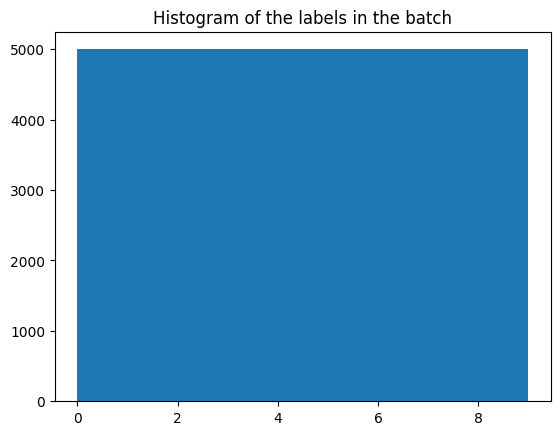

In [6]:
# i wan to compute for each class of the dataset the mean of the dataset
# and the covariance matrix of the dataset
# obtain the energy of a sample of a certain class
import matplotlib.pyplot as plt
import numpy as np

model = MODELS["SAT"]   

import pickle, os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = next(iter(TRAIN_DATALOADER))
# images
BATCH_IMAGES = BATCH[0].to(device)
# labels
BATCH_LABELS = BATCH[1].to(device)

# plot histopgram of the labels in the batch
plt.hist(BATCH_LABELS.cpu().numpy(), bins=10)
plt.title("Histogram of the labels in the batch")
plt.show()


## compute the average of the logits per class


In [7]:
# if os.path.exists("data/logits_mean_dict.pkl"):
#     with open("data/logits_mean_dict.pkl", "rb") as f:
#         logits_mean_dict = pickle.load(f)
    
#     with open("data/logits_dict.pkl", "rb") as f:
#         logits_dict = pickle.load(f)
# else:
    
logits_dict = {i:[ ]for i in range(10)}

for i in range(len(BATCH_IMAGES)):
    label = BATCH_LABELS[i].item()
    image = BATCH_IMAGES[i] 
    # compute the logit for the sample
    logits = model(image)
    #append in the dict
    logits_dict[label].append(logits[0].cpu().detach().numpy())

logits_mean_dict = {i:np.mean(np.array(logits_dict[i]), axis=0) for i in range(10)}
# save in a pickle file
with open("data/logits_mean_dict.pkl", "wb") as f:
    pickle.dump(logits_mean_dict, f)
with open("data/logits_dict.pkl", "wb") as f:
    pickle.dump(logits_dict, f)
    

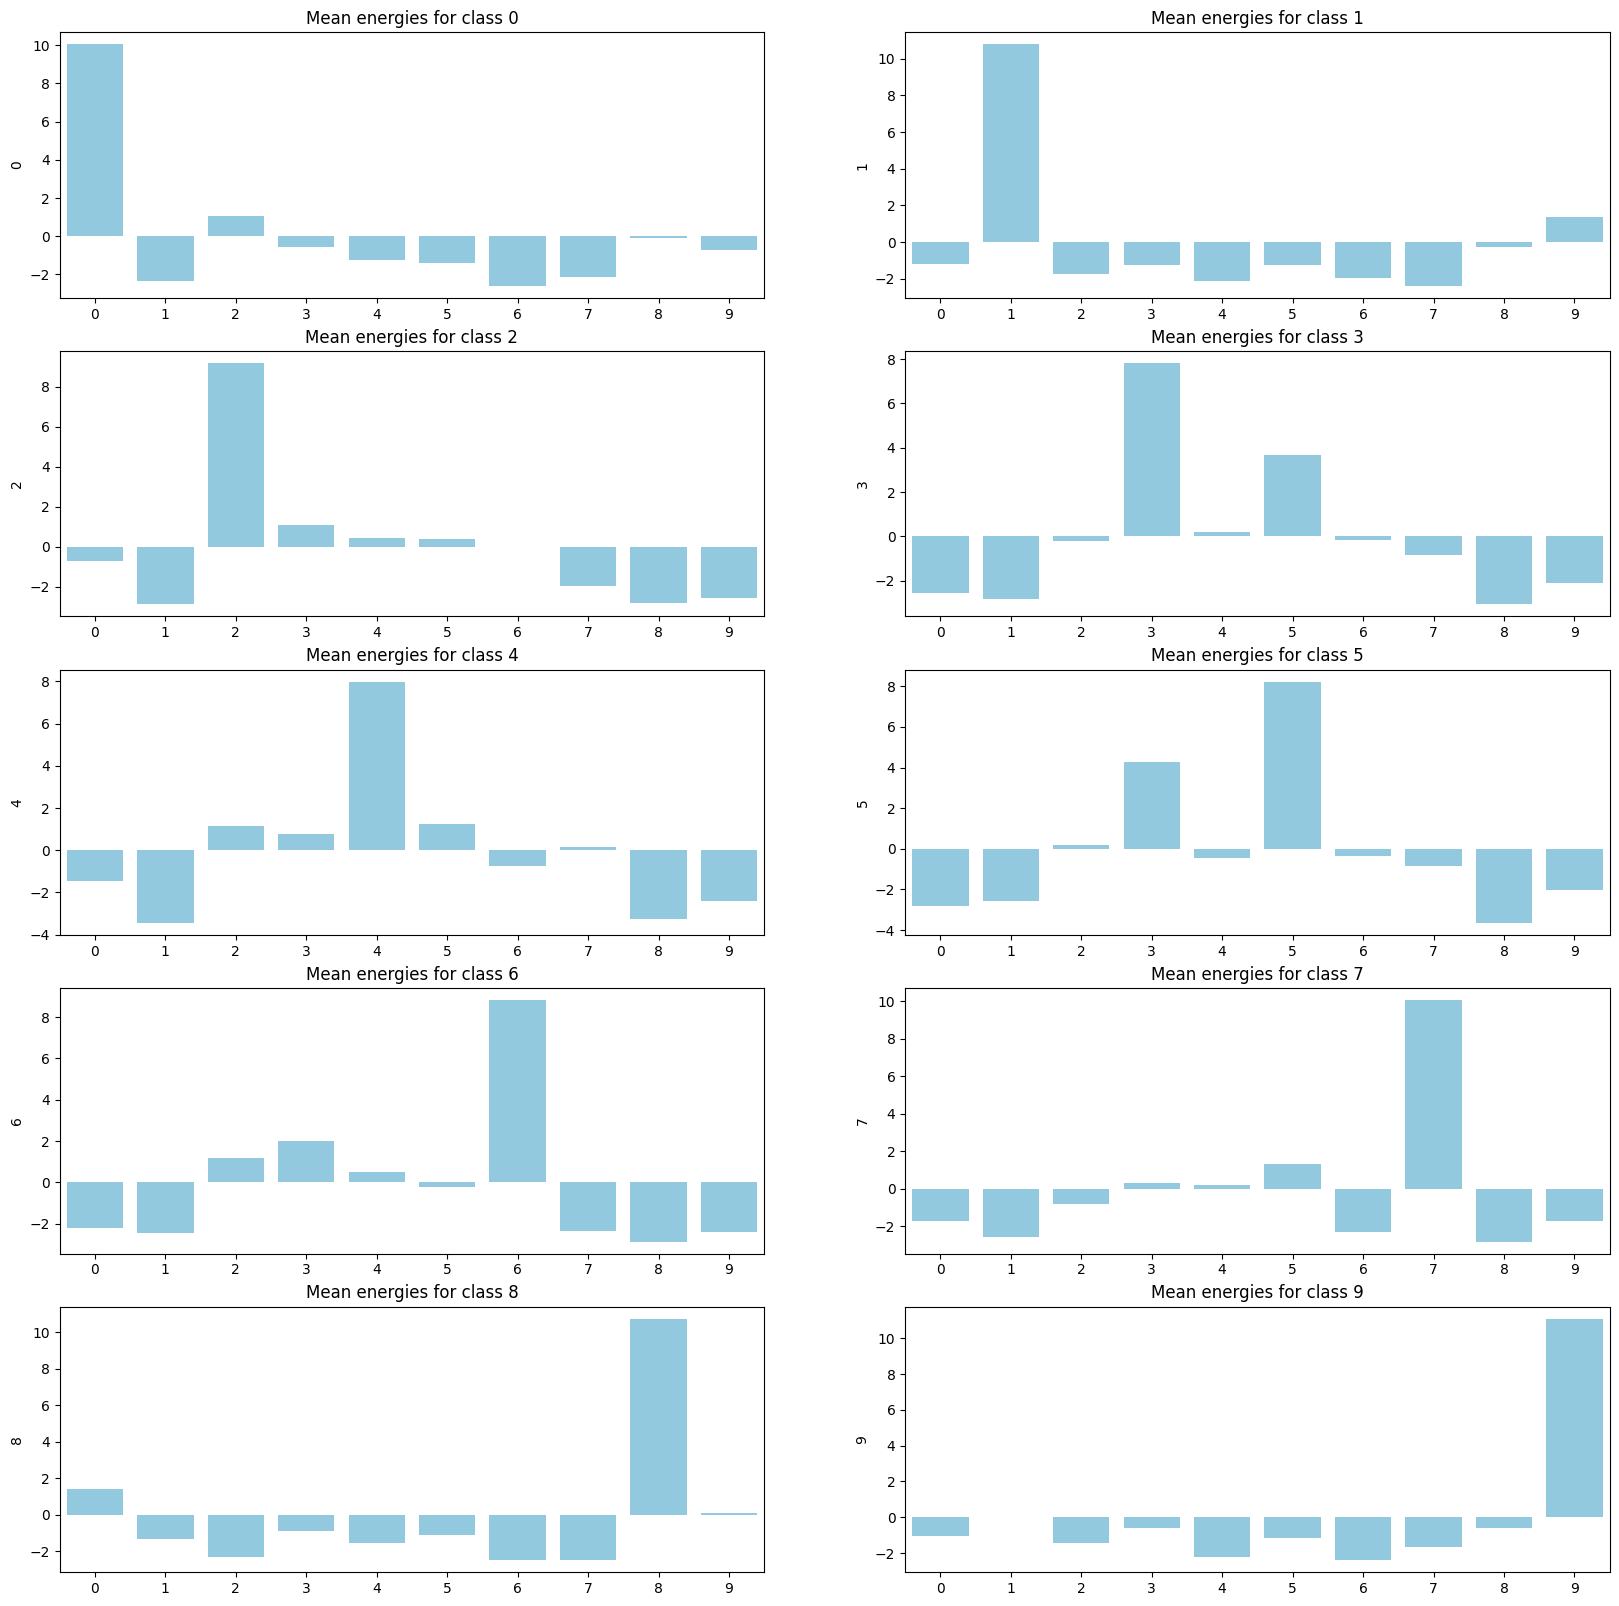

In [9]:
# visualize the mean of the logits for each class with seaborn in all different subplots
import seaborn as sns
import pandas as pd


# create a dataframe
df = pd.DataFrame(logits_mean_dict)
# plot
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
for i in range(10):
    sns.barplot(data=df[i], ax=ax[i//2, i%2],color="skyblue")
    ax[i//2, i%2].set_title(f"Mean energies for class {i}")
plt.show()

In [10]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
    
#compute the covariance matrix
cov_dict_inv = {i:[] for i in range(10)}
cov_dict = {i:[] for i in range(10)}

for key, value in logits_dict.items():
    cov = np.cov(np.array(value).T)
    cov_dict_inv[key] = np.linalg.inv(cov+np.eye(10,)*1e-3)
    cov_dict[key] = cov
with open("data/logits_cov_dict.pkl", "wb") as f:
    pickle.dump(cov_dict, f)
with open("data/logits_cov_dict_inv.pkl", "wb") as f:
    pickle.dump(cov_dict_inv, f)
    


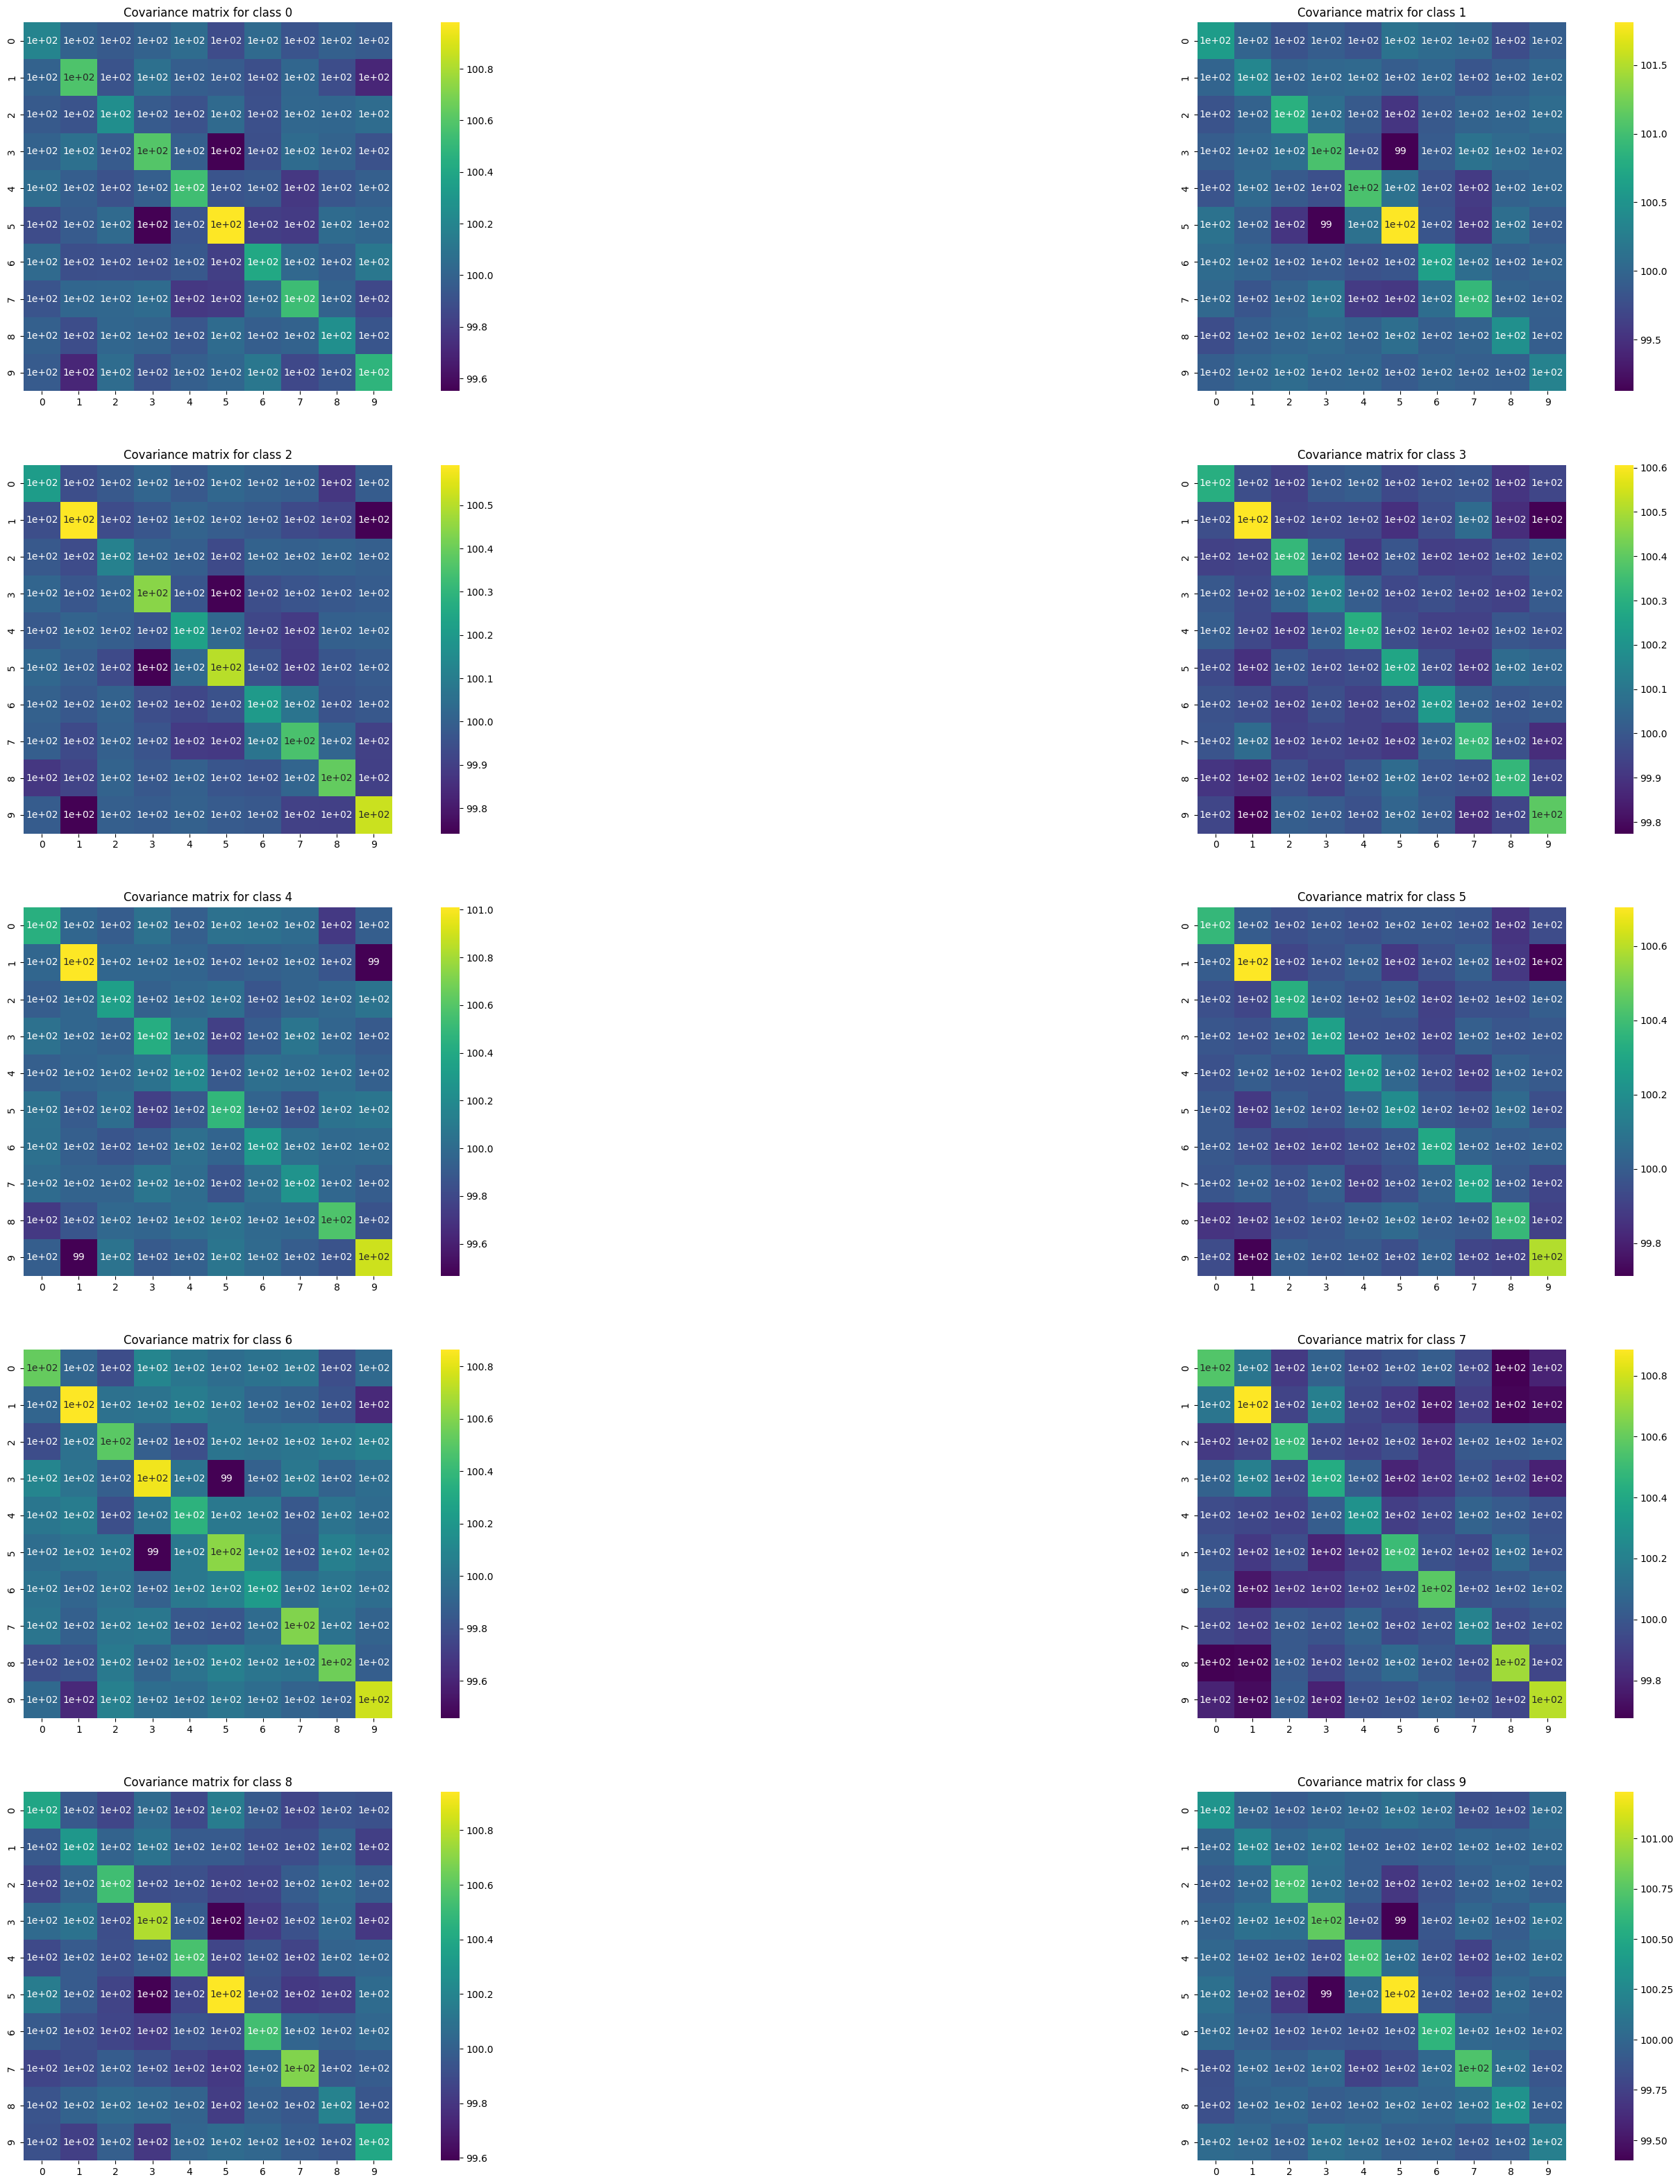

In [12]:
fig, ax = plt.subplots(5, 2, figsize=(40, 40))

for index in range(10):
    covariance_matrix = cov_dict_inv[index]

    df = pd.DataFrame(covariance_matrix)
    sns.heatmap(df, annot=True, cmap="viridis", ax=ax[index//2, index%2])
    ax[index//2, index%2].set_title(f"Covariance matrix for class {index}")
    # square aspect ratio
    ax[index//2, index%2].set_aspect("equal")
plt.show()



In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(40, 40))
for index in range (2):
    covariance_matrix = cov_dict_inv[index]
    df = pd.DataFrame(covariance_matrix)
    sns.heatmap(df, annot=True, cmap="viridis", ax=ax[index//2, index%2])
    ax[index//2, index%2].set_title(f"Covariance matrix for class {index}")
    # square aspect ratio
    ax[index//2, index%2].set_aspect("equal")
plt.show()


## compute the average of the energies per class
for each class submit the  samples to the model and compute the mutual energy for each of them 

In [ ]:
TRANSFORM = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
DATASET_TRAIN, DATASET_TEST = utils.load_clean_dataset(
    dataset=enumeration.BenchmarkDataset(dataset.lower()),
    n_examples=None,
    data_dir=data_dir,
    transform=TRANSFORM,
)
BATCH_SIZE = 100
print(BATCH_SIZE)
TRAIN_DATALOADER = torch.utils.data.DataLoader(
    DATASET_TRAIN, batch_size=BATCH_SIZE, shuffle=True
)

TEST_DATALOADER = torch.utils.data.DataLoader(
    DATASET_TEST, batch_size=BATCH_SIZE, shuffle=False
)

In [ ]:
from tqdm import tqdm
energy_dict = {i:[ ]for i in range(10)}
mean_energy_dict = {i:[] for i in range(10)} 
energies = []
for chunk in tqdm(TRAIN_DATALOADER):
    
    BATCH_IMAGES = chunk[0].to(device)
    # labels
    BATCH_LABELS = np.array(chunk[1]) 
    
    for index, pred in enumerate(BATCH_IMAGES):
        pred = model(pred)
        en_class = []
        for i in range (10):
            en_class_i = utils_func.compute_energy_xy(pred, i) # en_xy
            en_class.append(en_class_i.item()) # mutual energies of the class with all the other classes
        energy_dict[BATCH_LABELS[index].item()].append(torch.tensor(np.array(en_class)))

for i in range(10):
    mean_energy_dict[i] = torch.stack(energy_dict[i])

# compute the mean 
mean_energy_dict = {i:torch.mean(mean_energy_dict[i], axis=0) for i in range(10)}

In [18]:
import utils_func
if os.path.exists("data/energy_mean_dict.pkl"):
    with open("data/energy_mean_dict.pkl", "rb") as f:
        mean_energy_dict = pickle.load(f)
    
    with open("data/energy_dict.pkl", "rb") as f:
        energy_dict = pickle.load(f)
else:
    
    
# save in a pickle file
with open("data/energy_mean_dict.pkl", "wb") as f:
    pickle.dump(mean_energy_dict, f)
    
with open("data/energy_dict.pkl", "wb") as f:
    pickle.dump(energy_dict, f)
        

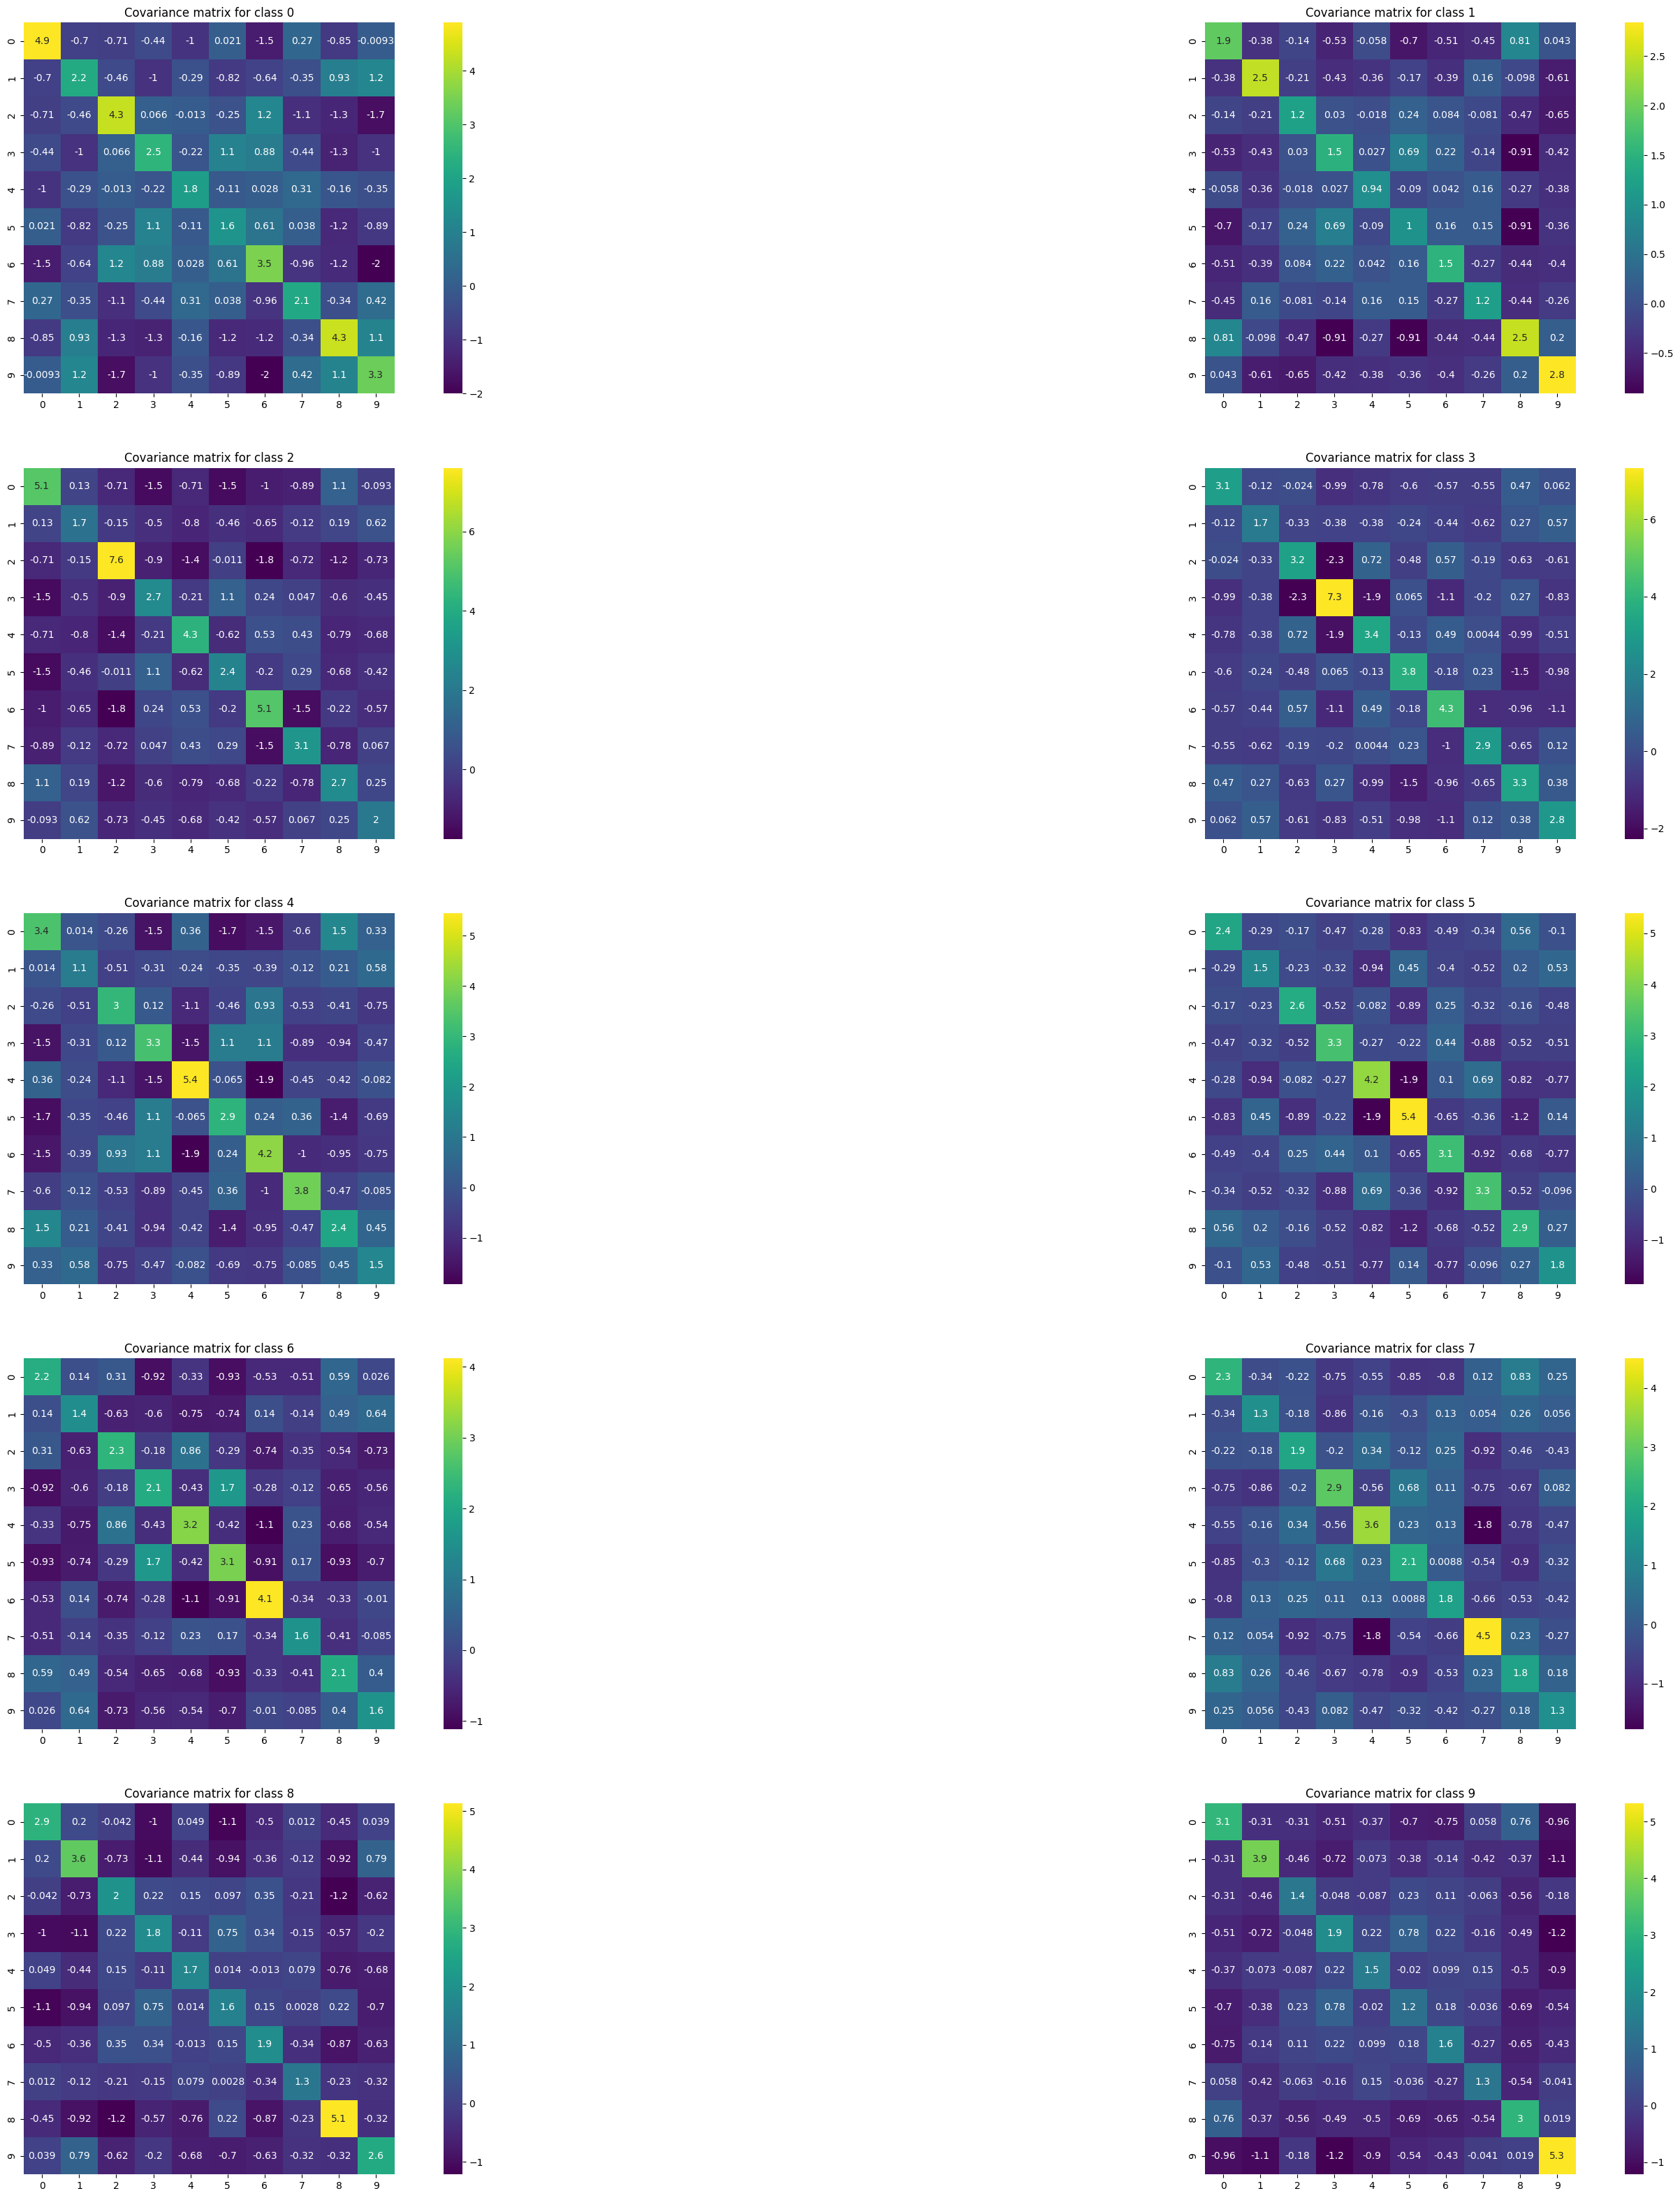

In [43]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
if os.path.exists("data/energy_cov_dict.pkl"):
    with open("data/energy_cov_dict.pkl", "rb") as f:
        cov_dict = pickle.load(f)
else:        
    #compute the covariance matrix
    cov_dict = {i:[] for i in range(10)}
    for key, value in energy_dict.items():
        cov_dict[key] = np.cov(np.array(value).T)
    
    
    with open("data/energy_cov_dict.pkl", "wb") as f:
        pickle.dump(cov_dict, f)
        
        
       
    
fig, ax = plt.subplots(5, 2, figsize=(40, 40))
for index in range (10):
    covariance_matrix = cov_dict[index]
    df = pd.DataFrame(covariance_matrix)
    sns.heatmap(df, annot=True, cmap="viridis", ax=ax[index//2, index%2])
    ax[index//2, index%2].set_title(f"Covariance matrix for class {index}")
    # square aspect ratio
    ax[index//2, index%2].set_aspect("equal")
plt.show()


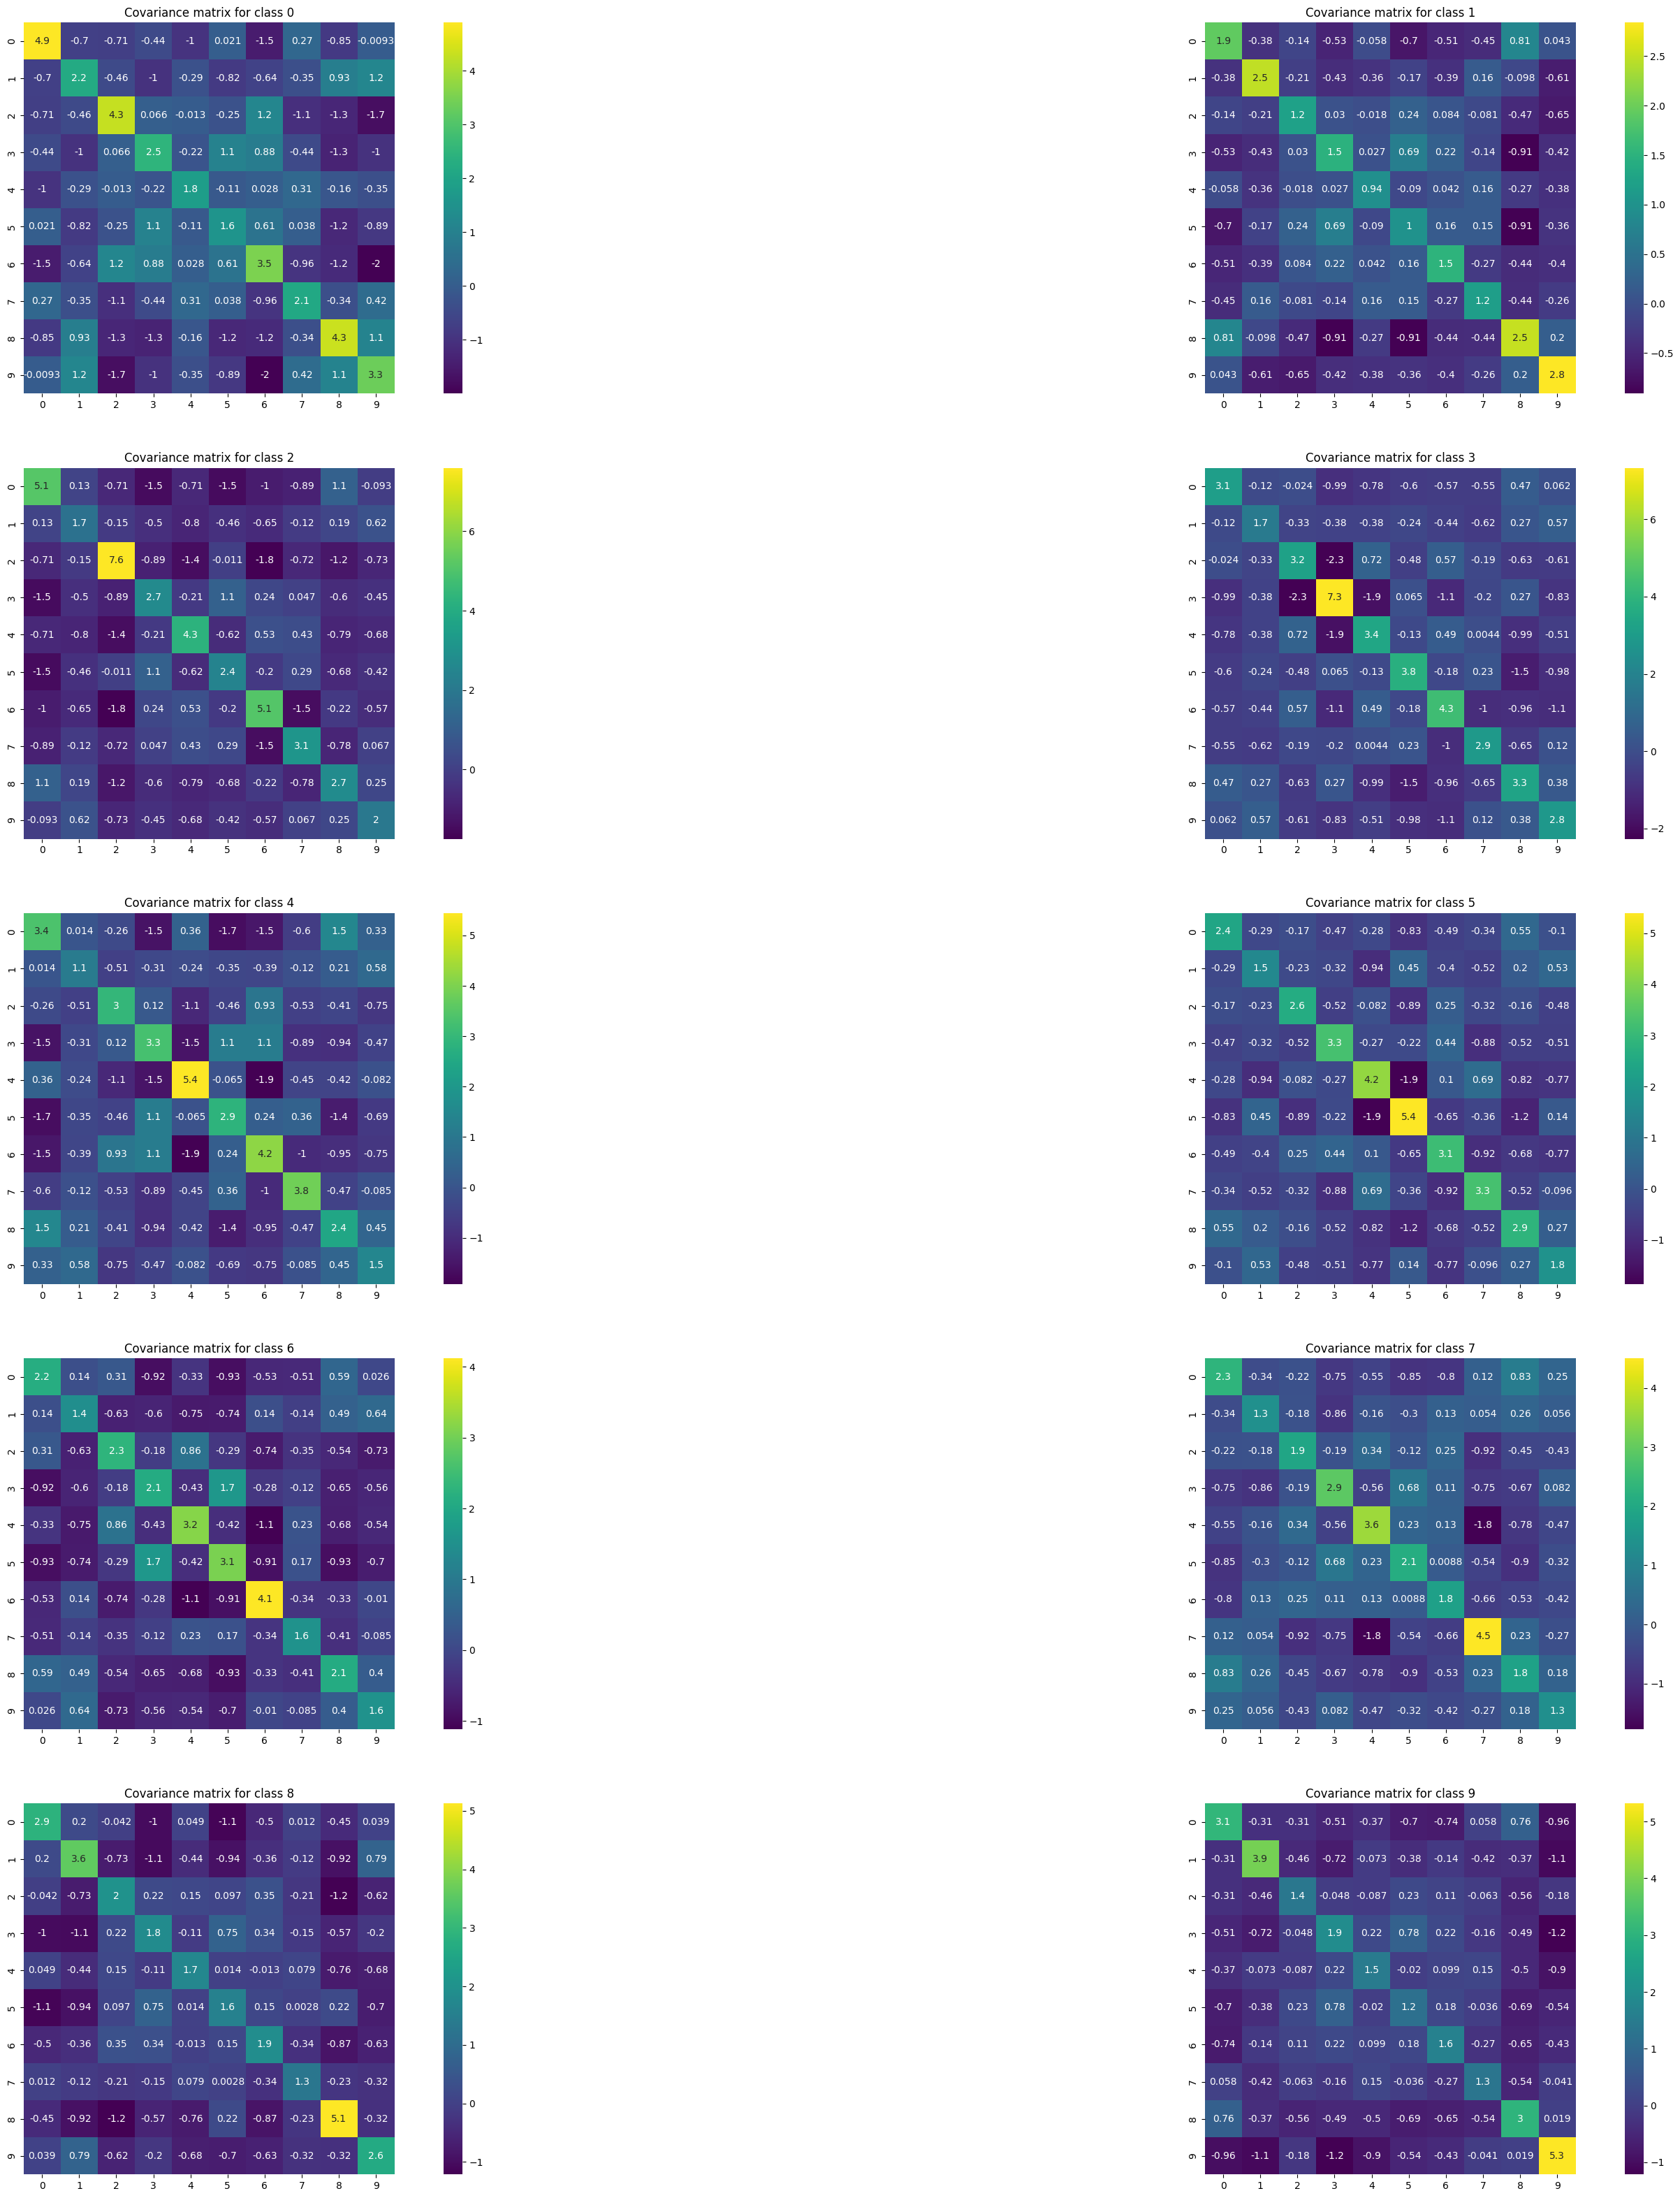

In [24]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance

cov_dict = {i:[] for i in range(10)}

# covariance 
for index in range(10):
    cov = EmpiricalCovariance(assume_centered=False).fit(np.array(logits_dict[index]))
    cov_dict[index] = cov.covariance_

# plot in all subplots the covariance matrix

fig, ax = plt.subplots(5, 2, figsize=(40, 40))
for index in range (10):
    covariance_matrix = cov_dict[index]
    df = pd.DataFrame(covariance_matrix)
    sns.heatmap(df, annot=True, cmap="viridis", ax=ax[index//2, index%2])
    ax[index//2, index%2].set_title(f"Covariance matrix for class {index}")
    # square plot

plt.show()


Model SAT loaded
